In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, SimpleRNN, RNN, LSTM, GRU, SpatialDropout1D, Dropout

In [2]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

In [3]:
import os, os.path, sys

In [4]:
path = r"C:\Users\mata2\Desktop\master\podaci\0k\X"

In [5]:
dir = os.listdir(path)

In [6]:
file_names = []
for file in dir:
    file_names.append(file)

In [7]:
percent_train = 0.8

In [8]:
train_files_names = file_names[:int(percent_train*len(file_names))]
test_file_names = file_names[int(percent_train*len(file_names))::]

In [9]:
x_command = np.asarray(pd.read_csv(r"C:\Users\mata2\Desktop\master\podaci\xCmd.txt",header=None).astype('int'))

In [10]:
train_ = np.concatenate([pd.read_csv(path + "/" + file, header=None)[:61000].astype('int')
                              for file in train_files_names], axis=0)
test_ = np.concatenate([pd.read_csv(path + "/" + file, header=None)[:61000].astype('int')
                              for file in test_file_names], axis=0)

In [11]:
for j in range(len(train_files_names)):
    exec(f"razlika_trening_{j} = []")
    for i in range(61000):
        exec(f"razlika_trening_{j}.append(x_command[i] - train_[j*61000+i])")
    exec(f'razlika_trening_{j} = np.asarray(razlika_trening_{j})')        

In [12]:
for j in range(len(test_file_names)):
    exec(f"razlika_test_{j} = []")
    for i in range(61000):
        exec(f"razlika_test_{j}.append(x_command[i] - test_[j*61000+i])")
    exec(f'razlika_test_{j} = np.asarray(razlika_test_{j})')    

In [13]:
def create_timeseries_split(data, time_steps):

  # Get the number of samples in the data
  num_samples = len(data) - time_steps

  # Create empty arrays to store features and target values
  x_train = np.zeros((num_samples, time_steps, 1))
  y_train = np.zeros((num_samples, 1))

  # Loop through the data and create features and target values
  for i in range(num_samples):
    # Extract a slice of data for the current feature
    x_train[i] = data[i:i+time_steps, :]

    # The target value is the next value after the feature
    y_train[i] = data[i+time_steps, 0]

  return x_train, y_train

In [14]:
time_steps = 8

In [15]:
for i in range(len(train_files_names)):
    exec(f'train_X_{i}, train_y_{i} = create_timeseries_split(razlika_trening_{i}, time_steps)')

In [16]:
for i in range(len(test_file_names)):
    exec(f'test_X_{i}, test_y_{i} = create_timeseries_split(razlika_test_{i}, time_steps)')

In [17]:
train_X = np.asarray(train_X_0)
for i in range(1,len(train_files_names)):
    exec(f'train_X = np.append(train_X, train_X_{i}, axis=0)')

In [18]:
train_y = np.asarray(train_y_0)
for i in range(1,len(train_files_names)):
    exec(f'train_y = np.append(train_y, train_y_{i}, axis=0)')

In [19]:
test_X = np.asarray(test_X_0)
for i in range(1,len(test_file_names)):
    exec(f'test_X = np.append(test_X, test_X_{i}, axis=0)')

In [20]:
test_y = np.asarray(test_y_0)
for i in range(1,len(test_file_names)):
    exec(f'test_y = np.append(test_y, test_y_{i}, axis=0)')

In [21]:
input_shape = (time_steps,1)

In [22]:
keras.utils.set_random_seed(7)
optimizerMSE = keras.optimizers.Adam(learning_rate=0.0001)

modelMSE = Sequential()
modelMSE.add(GRU(units = 16, input_shape = input_shape, activation = keras.layers.LeakyReLU()))
modelMSE.add(Dense(units = 8, activation=keras.layers.LeakyReLU()))
modelMSE.add(Dense(units = 8, activation=keras.layers.LeakyReLU()))
modelMSE.add(Dense(units = 1, activation=keras.layers.LeakyReLU(), bias_initializer='zeros', kernel_initializer='normal'))
modelMSE.compile(loss='mean_squared_error', optimizer = optimizerMSE)

In [23]:
historyMSE = modelMSE.fit(train_X, train_y, epochs=10, batch_size = 128, shuffle=False, verbose = 2)

Epoch 1/10

11436/11436 - 30s - loss: 9.6899 - 30s/epoch - 3ms/step
Epoch 2/10
11436/11436 - 27s - loss: 2.7692 - 27s/epoch - 2ms/step
Epoch 3/10
11436/11436 - 27s - loss: 2.4138 - 27s/epoch - 2ms/step
Epoch 4/10
11436/11436 - 27s - loss: 2.2920 - 27s/epoch - 2ms/step
Epoch 5/10
11436/11436 - 27s - loss: 2.2258 - 27s/epoch - 2ms/step
Epoch 6/10
11436/11436 - 28s - loss: 2.1853 - 28s/epoch - 2ms/step
Epoch 7/10
11436/11436 - 28s - loss: 2.1526 - 28s/epoch - 2ms/step
Epoch 8/10
11436/11436 - 29s - loss: 2.1236 - 29s/epoch - 3ms/step
Epoch 9/10
11436/11436 - 28s - loss: 2.0974 - 28s/epoch - 2ms/step
Epoch 10/10
11436/11436 - 28s - loss: 2.0768 - 28s/epoch - 2ms/step


In [24]:
train_scores = modelMSE.evaluate(test_X, test_y)

11436/11436 [==============================] - 16s 1ms/step - loss: 2.0296


In [25]:
train_predict_MSE = modelMSE.predict(train_X)
test_predict_MSE = modelMSE.predict(test_X)

11436/11436 [==============================] - 15s 1ms/step


In [26]:
# Plot the result
def plot_result(trainY, testY, x_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(x_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(train_y), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.title('Actual and Predicted Values. The Red Line Separates The Training And Test Examples')
    plt.show()

<IPython.core.display.Javascript object>


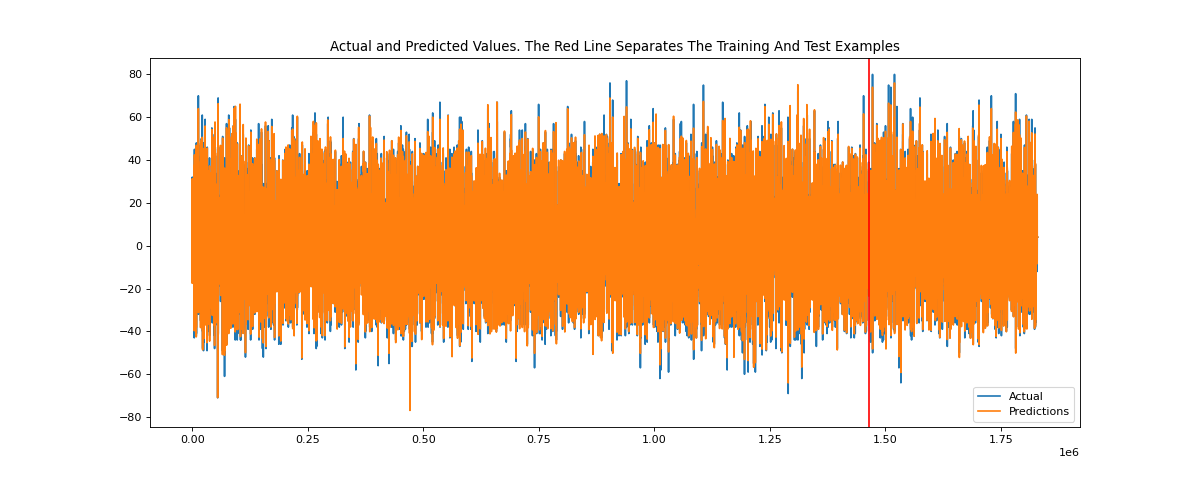

In [27]:
plot_result(train_y, test_y, train_predict_MSE, test_predict_MSE)

In [28]:
std_dev = []
with open(r"C:\Users\mata2\Desktop\master\Axis-projection-RNN\odstupanja\0k\std_dev.txt", 'r') as lines:
    for line in lines:
        std_dev.append(float(line.strip('\n')))

In [29]:
sr_vrednost = []
with open(r"C:\Users\mata2\Desktop\master\Axis-projection-RNN\odstupanja\0k\sr_vrednost.txt", 'r') as lines:
    for line in lines:
        sr_vrednost.append(float(line.strip('\n')))

In [30]:
mean_1std = 0
for j in range(len(test_file_names)):
    for i in range(int(len(test_predict_MSE)/len(test_file_names))):
        if sr_vrednost[i+time_steps] - std_dev[i+time_steps] <= test_predict_MSE[int(len(test_predict_MSE)/len(test_file_names))*j + i] <= sr_vrednost[i+time_steps] + std_dev[i+time_steps]:
            mean_1std += 1
        #else:
            #print(sr_vrednost[i+8], std_dev[i+8], test_predict_MSE[60992*j + i], 'index:',j*60992 + i)
mean_1std/len(test_predict_MSE)

0.5846313177684505

In [31]:
mean_3std = 0
for j in range(len(test_file_names)):
    for i in range(int(len(test_predict_MSE)/len(test_file_names))):
        if sr_vrednost[i+time_steps] - 3*std_dev[i+time_steps] <= test_predict_MSE[int(len(test_predict_MSE)/len(test_file_names))*j + i] <= sr_vrednost[i+time_steps] + 3*std_dev[i+time_steps]:
            mean_3std += 1
        #else:
            #print(sr_vrednost[i+8], std_dev[i+8], test_predict_MSE[60992*j + i], 'index:',j*60992 + i)
mean_3std/len(test_predict_MSE)

0.9916245846449807

In [32]:
min_kord = [float('inf') for x in range(61000)]
max_kord = [float('-inf') for x in range(61000)]

for i in range(61000):    
    for j in range(len(train_files_names)):
        exec(f'current_file = razlika_trening_{j}')
        if current_file[i][0] < min_kord[i]:
            min_kord[i] = current_file[i][0]
        if current_file[i][0] > max_kord[i]:
            max_kord[i] = current_file[i][0]

ako predikciju bacimo u int (zaokruzimo pre toga preko np.round(x,0))

In [33]:
i = 8
uspeli_minmax = 0
for j in range(len(test_predict_MSE)):
    if i%61000 == 0:
        i = 8
    if min_kord[i] <= np.round(test_predict_MSE[j],0) <= max_kord[i]:
        uspeli_minmax += 1
    i += 1
uspeli_minmax/len(test_predict_MSE)

0.9291355150402238

<IPython.core.display.Javascript object>


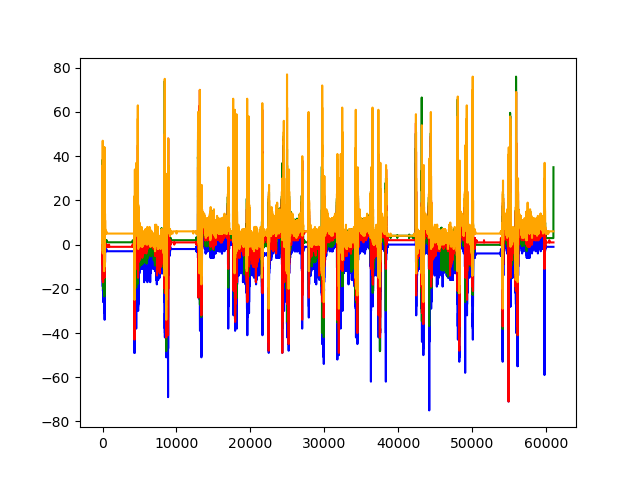

In [34]:
plt.plot(min_kord,'blue')
plt.plot(test_predict_MSE[:61000], 'green')
plt.plot(razlika_trening_0, 'r')
plt.plot(max_kord,'orange')
plt.show()

In [35]:
modelMSE.save(r"C:\Users\mata2\Desktop\master\Axis-projection-RNN\modeli\Difference predictions")

INFO:tensorflow:Assets written to: C:\Users\mata2\Desktop\master\Axis-projection-RNN\modeli\Difference predictions\assets


INFO:tensorflow:Assets written to: C:\Users\mata2\Desktop\master\Axis-projection-RNN\modeli\Difference predictions\assets


<IPython.core.display.Javascript object>


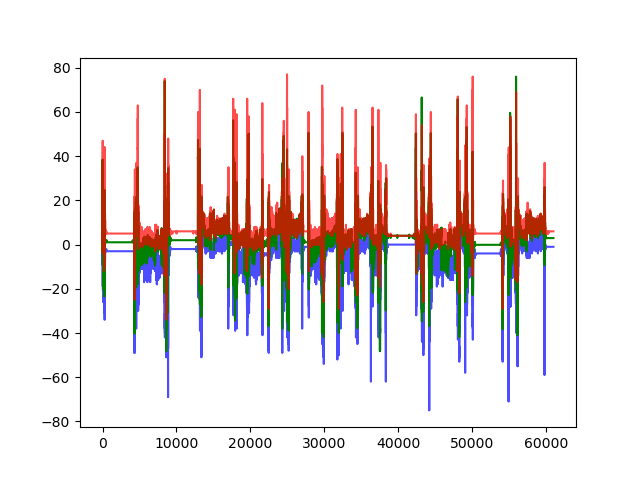

In [36]:
plt.plot(min_kord,'b', alpha = 0.7)
plt.plot(test_predict_MSE[:60992], 'g')
plt.plot(max_kord,'r', alpha = 0.7)
plt.show()

In [37]:
min_kord_reshape = []
for i in range(len(test_file_names)):
    min_kord_reshape.append(min_kord)
min_kord_reshape = np.asarray(min_kord_reshape).flatten()

In [38]:
max_kord_reshape = []
for i in range(len(test_file_names)):
    max_kord_reshape.append(max_kord)
max_kord_reshape = np.asarray(max_kord_reshape).flatten()

<IPython.core.display.Javascript object>


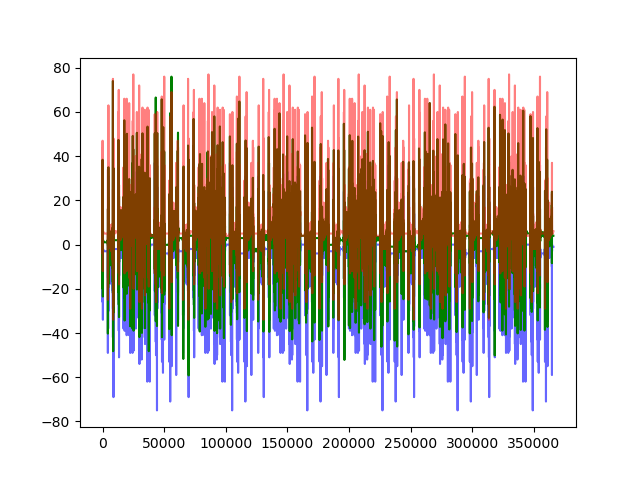

In [39]:
plt.plot(min_kord_reshape,'b', alpha = 0.6)
plt.plot(test_predict_MSE, 'g')
plt.plot(max_kord_reshape,'r',alpha = 0.5)
plt.show()